In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
and then re-execute this cell.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [5]:
#Importation of packages and datasets
import os 
from tqdm import tqdm
from glob import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf

from warnings import filterwarnings
filterwarnings('ignore')


print(os.getcwd())
path_cwd = os.getcwd()

X_train = pd.read_csv('/content/drive/MyDrive/Thesis/RFMiD_Challenge_Dataset/Groundtruths/a. RFMiD_Training_Labels.csv')
X_val = pd.read_csv('/content/drive/MyDrive/Thesis/RFMiD_Challenge_Dataset/Groundtruths/b. RFMiD_Validation_Labels.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Thesis/RFMiD_Challenge_Dataset/Groundtruths/c. RFMiD_Testing_Labels.csv')

/content


In [6]:
X_train.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
X_train.describe()
#No missing value

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,960.500000,0.791146,0.195833,0.052083,0.165104,0.071875,0.052604,0.038021,0.096875,0.007292,0.024479,0.007812,0.019271,0.146875,0.014583,0.003125,0.008333,0.033854,0.030208,0.002604,0.008854,0.005729,0.007292,0.022396,0.016667,0.007812,0.011458,0.005729,0.003125,0.017708
std,554.400577,0.406596,0.396944,0.222253,0.371371,0.258348,0.223300,0.191296,0.295865,0.085102,0.154572,0.088065,0.137511,0.354073,0.119909,0.055829,0.090930,0.180901,0.171205,0.050978,0.093703,0.075494,0.085102,0.148006,0.128052,0.088065,0.106456,0.075494,0.055829,0.131924
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,480.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,960.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1440.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1920.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#reconstituion link image + drop ID feature
X_train['filename'] = X_train.apply(lambda x : "/content/drive/MyDrive/Thesis/RFMiD_Challenge_Dataset/Original Images/Training Set/" +str(x['ID']) + ".png", axis=1)
X_val['filename'] = X_val.apply(lambda x : "/content/drive/MyDrive/Thesis/RFMiD_Challenge_Dataset/Original Images/Validation Set/" +str(x['ID']) + ".png", axis=1)
X_test['filename'] = X_test.apply(lambda x : "/content/drive/MyDrive/Thesis/RFMiD_Challenge_Dataset/Original Images/Testing Set/" +str(x['ID']) + ".png", axis=1)

X_train = X_train.drop('ID', axis=1)
X_val = X_val.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

In [9]:
print(X_train.head(1))
print(X_train.shape)
#30 class + risk evaluation (30 features)

   Disease_Risk  DR  ...  OTHER                                           filename
0             1   1  ...      0  /content/drive/MyDrive/Thesis/RFMiD_Challenge_...

[1 rows x 30 columns]
(1920, 30)


In [10]:
#datasets
X_train_img = X_train['filename']
X_val_img = X_val['filename']
y_train = X_train.drop(['filename'], axis=1)
y_val = X_val.drop(['filename'], axis=1)

print('shape of X_train:', X_train_img.shape)
print('shape of Validation:', X_val_img.shape)
print('shape of y_train:', y_train.shape)
print('shape of y_val:', y_val.shape)

shape of X_train: (1920,)
shape of Validation: (640,)
shape of y_train: (1920, 29)
shape of y_val: (640, 29)


In [11]:
#Plot some random images
import cv2
import random
def plotImages():
    i=1
    plt.figure(figsize=(15,10))
    for r in random.sample(glob(path_cwd + '/Thesis/RFMiD_Challenge_Dataset/Original Images/Training Set/**'), 15):
      plt.subplot(3,5,i)
      img = cv2.imread(r)
      img = tf.reverse(img, axis=[-1])
      img =  tf.image.adjust_contrast(img, 1.5)
      plt.imshow(img)
      i+=1
      plt.axis('off')

In [12]:
#plotImages() #Seems we have to convert to RGB format

# **Image Preprocessing**

In [13]:
IMG_SHAPE = (250, 400)
BATCH_SIZE = 64

In [31]:
@tf.function

#Fonction pour prprocessing des images
def scale_down(img):
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, (250, 400), method='nearest')
    img = (img / 255)
    
    return img

#Preprocessing du jeu d'entrainement
def preprocessing_data(img):
   
    #Lecture et décodage des images:
    img = tf.io.read_file(img)
    img = tf.io.decode_png(img, channels=3)

    #adjust contrast
    img =  tf.image.adjust_contrast(img, 1.35)

    #Resize
    img = scale_down(img)

    return img

In [32]:
#Datasets preprocessing
AUTO = tf.data.experimental.AUTOTUNE

y_train = np.array(y_train).astype('float32')
y_val = np.array(y_val).astype('float32')

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_img, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_img, y_val))

dataset_train=(dataset_train
               .shuffle(1000)
               .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
               .batch(BATCH_SIZE, drop_remainder=True)
               .prefetch(AUTO)
               )

dataset_val=(dataset_val
             .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
             .batch(BATCH_SIZE, drop_remainder=True)
             .prefetch(AUTO)
             )


print(dataset_train)
print(dataset_val)

<PrefetchDataset shapes: ((64, 250, 400, 3), (64, 29)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((64, 250, 400, 3), (64, 29)), types: (tf.float32, tf.float32)>


In [33]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


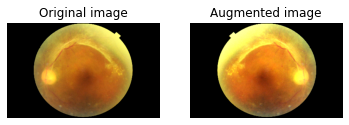

In [34]:
image, label = next(iter(dataset_train))
image, label = image.numpy()[0], label.numpy()[0]


flipped = tf.image.flip_left_right(image)
flipped =  tf.image.adjust_contrast(flipped, 1.35)
visualize(image, flipped)

In [35]:
#API keras preparation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, Activation, MaxPool2D, Dense, Flatten, GlobalAvgPool2D
from keras import backend as K
from tensorflow.keras.applications import VGG16
vgg16 = VGG16()

#for layer in xception.layers:
#    print(layer.name, layer)

# ***Classification model***

In [43]:
shape = (250, 400,3)

def Layers(inputs, trainable=False):
    global vgg16_model
    vgg16_model = VGG16(weights='imagenet' ,
                        include_top=False,
                        input_tensor=inputs)
    
    if trainable == True:
        for layer in vgg16_model.layers:
            layer.trainable = True
            
    else:
        vgg16_model.trainable = False
            
    return vgg16_model.output
    
        
def Build_VGG16(trainable=False):
    
    inputs = Input(shape=shape)
    vgg16 = Layers(inputs, trainable)

    conv1 = Flatten()(vgg16_model.output)
    
    dense2 = Dense(256,activation='relu')(conv1)
    dense2 = Dropout(rate=0.2)(dense2)
    
    dense3 = Dense(128,activation='relu')(dense2)
    dense3 = Dropout(rate=0.2)(dense3)
    
    model = Dense(29,activation= 'sigmoid')(dense3)
    
    return Model(inputs=inputs, outputs = model)

model = Build_VGG16()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 100, 128)      0   

# use a LR function to adapt Gradient
# Class imbalanced, we create a loss fonction to adjust weight 

In [44]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    
    #base_lr: the starting learning rate
    #lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    #decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    #spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    #spike_multiple: the multiple applied to the current learning rate for a spike.
    

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):

        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type] 
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]


            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:
            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)

callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=2)

In [46]:
    #Re-Weighting classes binary crossentropy

    def dyn_weighted_bincrossentropy(true, pred):

        # get the total number of inputs
        num_pred = K.sum(K.cast(pred < 0.5, true.dtype)) + K.sum(true)
        # get weight of values in 'pos' category
        zero_weight =  K.sum(true)/ num_pred +  K.epsilon() 
        # get weight of values in 'false' category
        one_weight = K.sum(K.cast(pred < 0.5, true.dtype)) / num_pred +  K.epsilon()
        # calculate the weight vector
        weights =  (1.0 - true) * zero_weight +  true * one_weight 
        # calculate the binary cross entropy
        bin_crossentropy = K.binary_crossentropy(true, pred)
        # apply the weights
        weighted_bin_crossentropy = weights * bin_crossentropy 

        return K.mean(weighted_bin_crossentropy)


    def weighted_bincrossentropy(true, pred, weight_zero = 0.25, weight_one = 1):

        # calculate the binary cross entropy
        bin_crossentropy = K.binary_crossentropy(true, pred)
        # apply the weights
        weights = true * weight_one + (1. - true) * weight_zero
        weighted_bin_crossentropy = weights * bin_crossentropy 

        return K.mean(weighted_bin_crossentropy)

In [39]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=5000, from_logits=True, name='pr_metric') # The higher the threshold value, the more accurate it is calculated.
roc_metric = AUC(curve='ROC', num_thresholds=5000, from_logits=True, name='roc_metric') 

In [47]:
model.compile(loss=dyn_weighted_bincrossentropy,
              optimizer =tf.keras.optimizers.Adam(),
              metrics= [roc_metric, pr_metric])

#weighted_binary_crossentropy

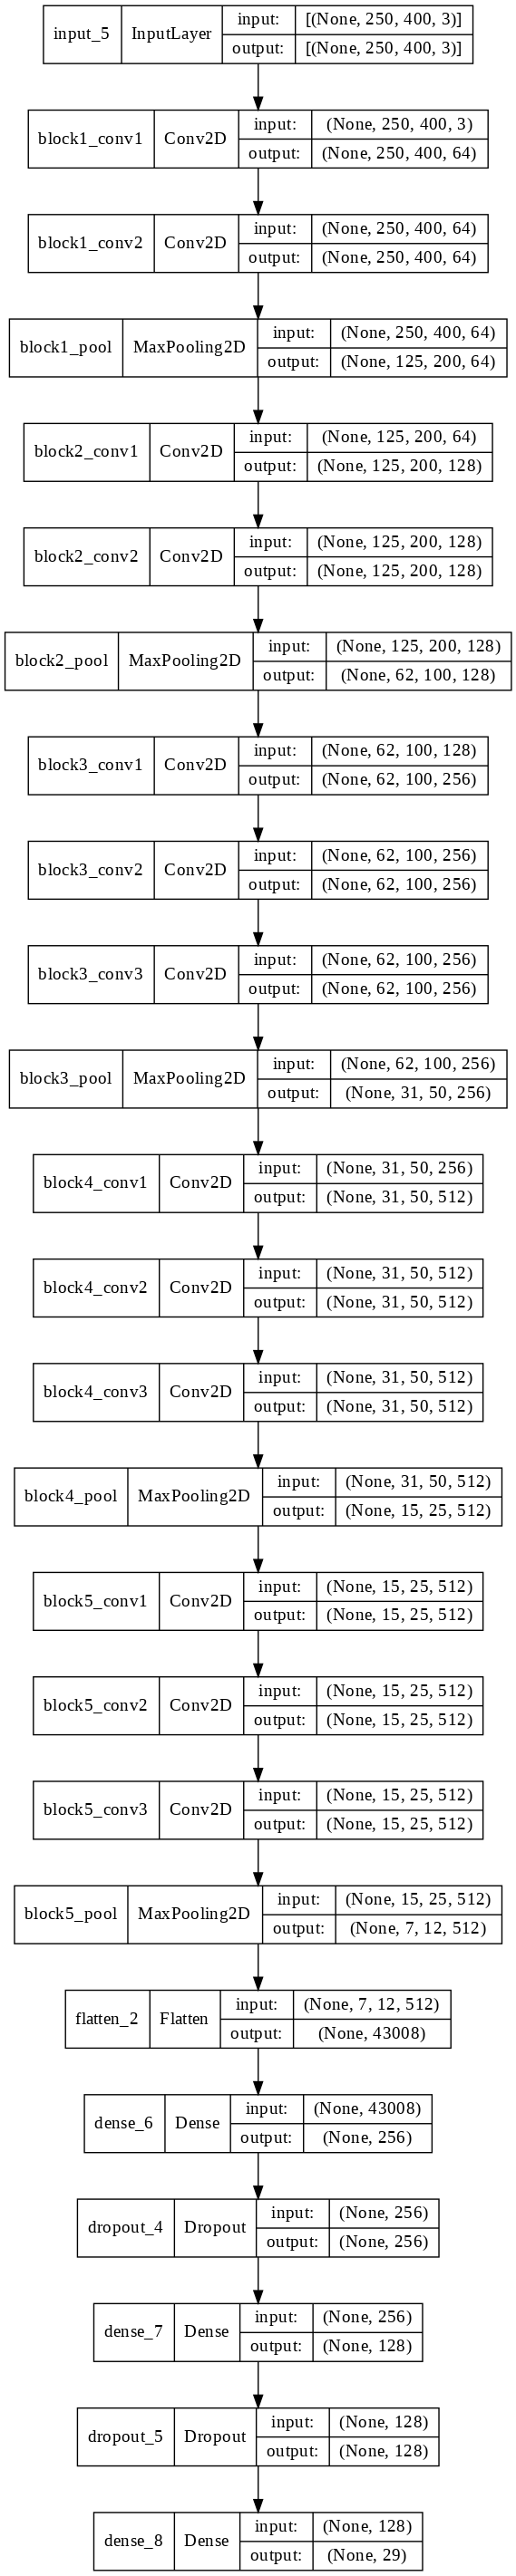

In [48]:
tf.keras.utils.plot_model(model, 'retinal_output_model.png', show_shapes=True, dpi=100)

In [ ]:
history = model.fit(dataset_train, validation_data=dataset_val, epochs=15, verbose=1, callbacks=callback_lr)

Setting learning rate to 0.001
Epoch 1/15
30/30 [==============================] - 2823s 94s/step - loss: 0.0882 - roc_metric: 0.8212 - pr_metric: 0.3693 - val_loss: 0.0534 - val_roc_metric: 0.8799 - val_pr_metric: 0.6083
Setting learning rate to 0.001
Epoch 2/15
 5/30 [====>.........................] - ETA: 27:34 - loss: 0.0617 - roc_metric: 0.8641 - pr_metric: 0.5338